# TTT4185 Machine learning for Speech technology

## Computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful plotting commands from `matplotlib.pyplot`: `figure`, `plot`, `subplots`, `pcolormesh`

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $f_0$ of the vowel.

16000


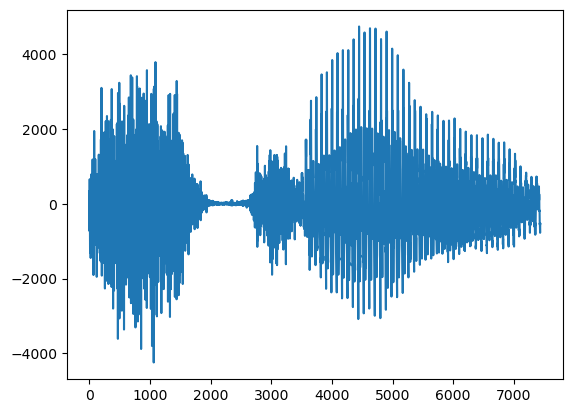

In [2]:
import scipy.io.wavfile
Fs, data = scipy.io.wavfile.read('stry(1).wav')

import matplotlib.pyplot as plt
import scipy as sp

print(Fs)

plt.plot(data)
plt.show()

The characteristics about the sound /s/ is that it is fairly long and has a large value.
The sound /t/ is short due to the plosive nature of the sound.
The /r/ is more rounded which gives it a larger value, and it is kind of added into the /iy/ sound.
The /iy/ is a vowel-like sound which slowly 'dies out'.

Another property that might be more difficult to distinguish is that only the /iy/ and partly the /r/ sound is periodic whilst the /s/ and /t/ is more sudden. This is due to /s/ being a fricative and /t/ being plosive.

With a sampling frequency of 16kHz: 40ms -> 0.04 $\cdot$ 16000 = 640 samples

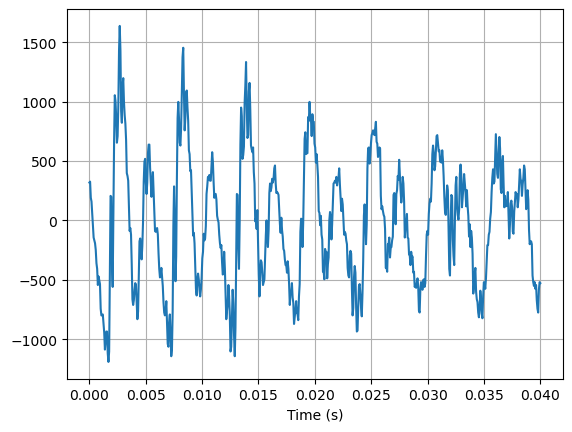

In [3]:
import numpy as np

t = np.linspace(0, 0.04, 640)

plt.plot(t, data[-640:])
plt.grid()
plt.xlabel("Time (s)")
plt.show()

The distance between two peaks, which is roughly the period, is approximately 75 samples.
This is equal to a frequency of $\frac{16000}{75}$ = 213 Hz (sampling frequency/samples).
Thus $f_0$ is approximately 213 Hz.

(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the spectrum expressed in dBs ($20 \log_{10}(x)$) as a function of frequency.
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $f_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

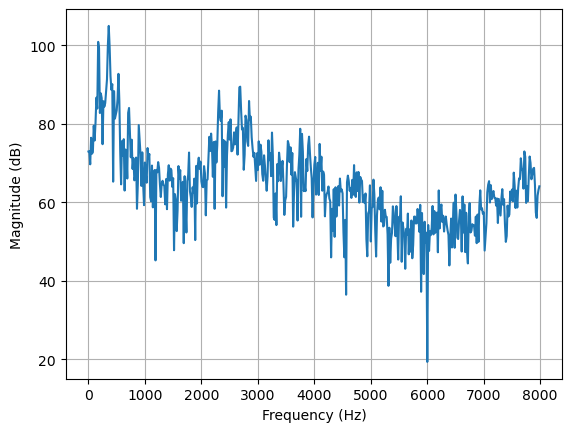

In [4]:
spectrum = np.fft.fft(data[-640:], 1024)
freq     = np.fft.fftfreq(1024, 1/Fs)
N        = len(spectrum)

plt.plot(freq[:N//2], 20*np.log10(np.abs(spectrum))[:N//2])
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

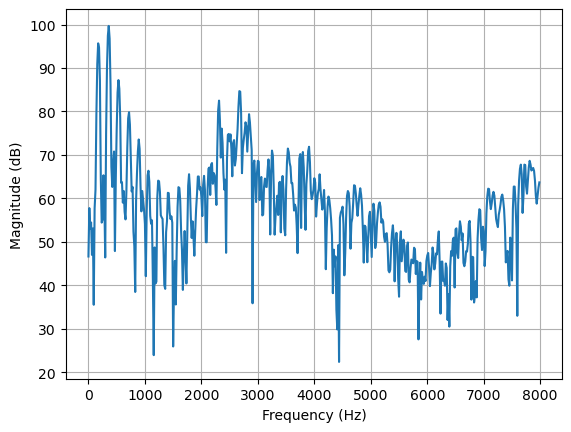

In [5]:
window       = sp.signal.windows.hamming(len(data[-640:]))
dataWindowed = data[-640:]*window

spectrumWindowed = np.fft.fft(dataWindowed, 1024)
freqWindowed     = np.fft.fftfreq(1024, 1/Fs)

plt.plot(freqWindowed[:N//2], 20*np.log10(np.abs(spectrumWindowed))[:N//2])
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

By using a window such as Hanning, one reduces the magnitude of the side lobes in exchange for a wider main lobe.

The consequence of this is that the spectrum becomes less precise in terms of frequency due to a wider main lobe, but the overall spectrum might be more accurate due to not being affected as much by the side lobes.

The fundamental frequency is the frequency of the lowest peak in the spectrum. This can be estimated by: $f_0$ ≈ frequency interval / amount of peaks in interval.

$f_0$ ≈ 1000/5 = 200 Hz

The deviation between this estimation and the earlier estimation is most likely due to the inaccuracy when interpreting the plots.

The calculation can be done in this way due to the harmonics of the fundamental frequency being periodic in the spectrum.

A rough estimate for the formants is: F1 = 300 Hz and F2 = 2500 Hz.

This estimate is found by 'looking for' the general shape of the formants from the spectrums.

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the spectrum in dBs as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it not possible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`. Check the documentation of the sptk package https://netix.dl.sourceforge.net/project/sp-tk to know which parameters are returned by the `lpc` function, and what model they correspond to.

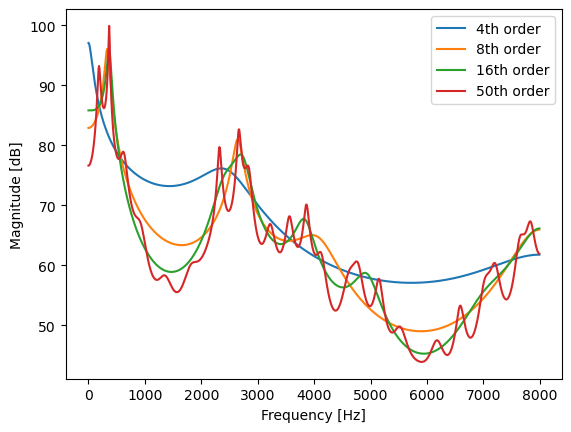

In [14]:
import pysptk

def getEstimate(order):
    # coefficients = pysptk.sptk.lpc(data[-640:], order)
    coefficients = pysptk.sptk.lpc(dataWindowed, order)
    poles        = [1]
    for c in coefficients[1:]: poles.append(c)

    frequencies, estimatedSpectrum = sp.signal.freqz(b = coefficients[0], a = poles, worN = 1024, fs = Fs)
    return frequencies, estimatedSpectrum

f4,  eS4  = getEstimate(4)
f8,  eS8  = getEstimate(8)
f16, eS16 = getEstimate(16)
f50, eS50 = getEstimate(50)

plt.plot(f4,  20*np.log10(abs(eS4)))
plt.plot(f8,  20*np.log10(abs(eS8)))
plt.plot(f16, 20*np.log10(abs(eS16)))
plt.plot(f50, 20*np.log10(abs(eS50)))
plt.legend(["4th order", "8th order", "16th order", "50th order"])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.show()


The estimated spectrum is a lot cleaner, due to it being an estimation based on an AR-process and not a real sampled signal. Where as the previous spectrum had a lot of peaks closer to each other, the spectrum using LPC is smoother as mentioned with fewer peaks. This is due to there being a limitation on the amount of poles in the filter (order of the AR-process).

The problem with using LPC is the evaluation of optimal order for the filter. A too low order results in too few poles, underfitting. This gives a spectrum which does not include all the formants. An order that is too high results in overfitting, which in turn results in a spectrum that is difficult to interpret since it has too many peaks. By using enough poles, we are able to also view the outline of the harmonics.

Using an LPC model, we model the speech signal as an output signal from a source through a series of tubes, which represents the cavities (oral for voiced speech). Each pole in the model represents a tube.

In our case, the 4th and 50th order results in under- and overfitting respectively. The 8th and 16th order filters are relatively alike, but the 16th might be the better spectrum.

Since the AR-process is using a limited amount of poles and no zeros, the LPC filter does not model the source, only the filter (tube model). Since the source is where the fundamental frequency is generated, we are not able to determine this frequency using the LPC filter.

(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjusting the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

In [15]:
def plotSpectrogram(windowLength, overlap = None):
    spectrogramWindow = sp.signal.windows.hamming(windowLength)
    f, t, Sdata       = scipy.signal.spectrogram(data, fs = Fs, window = spectrogramWindow, noverlap = overlap)

    plt.figure(figsize=(4,2))
    plt.pcolormesh(t, f, Sdata, shading = "gouraud")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

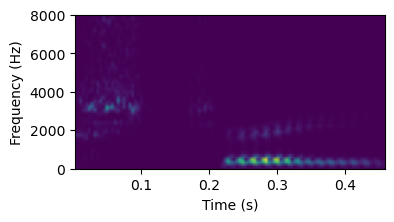

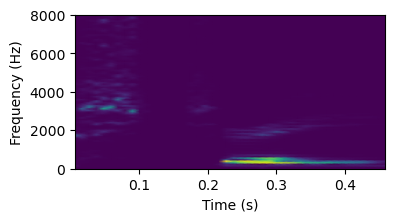

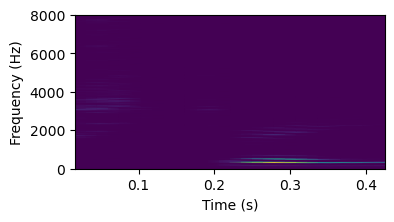

In [16]:
plotSpectrogram(100, 32)
plotSpectrogram(200, 32)
plotSpectrogram(500, 32)

Increasing the window length with a constant overlap reduces the time resolution but increases the frequency resolution, as expected.

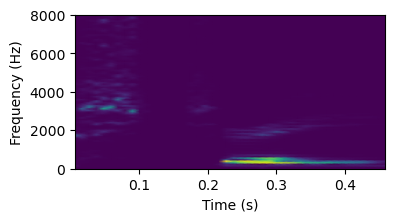

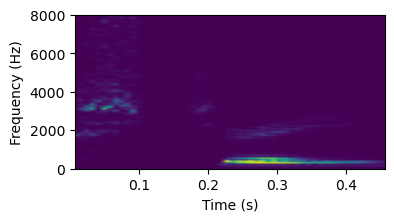

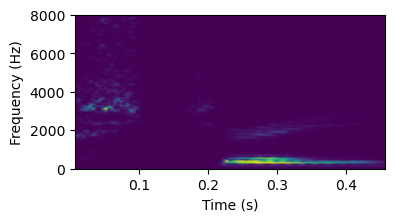

In [17]:
plotSpectrogram(200, 32)
plotSpectrogram(200, 64)
plotSpectrogram(200, 128)

Increasing the overlap but keeping the window length constant does not change the spectrum for the voiced speech much, but the spectrum for the voiceless fricatives changes. The peaks in the spectrum becomes more prominent.

The larger overlap means that we are viewing more the correlation in time between the samples. Since the fricative /s/ has a spectrum with no prominent formants, we are able to improve the spectrum by getting a larger time correlation.

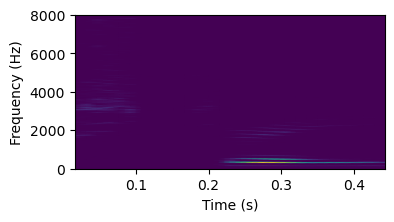

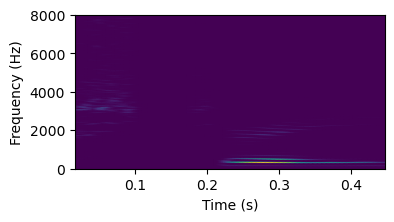

In [19]:
plotSpectrogram(500, 256)
plotSpectrogram(500, 400)

When having a larger overlap but also a large window, the frequency resolution becomes so large that overlap doesn't improve the spectrum much for the fricatives.

From the spectrogram one can see that the /r/ and the /iy/ sound consists of more low frequencies (<2000 Hz), whilst the /s/ sound consists of higher than this (3000 - 4000 Hz). The /t/ sound is also around 3500 Hz.

The main difference between the /s/ and /t/ sound is that /s/ has more spread across frequencies.

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

The real cepstrum is defined as the inverse FFT of $\log_{10}(|X(w)|)$

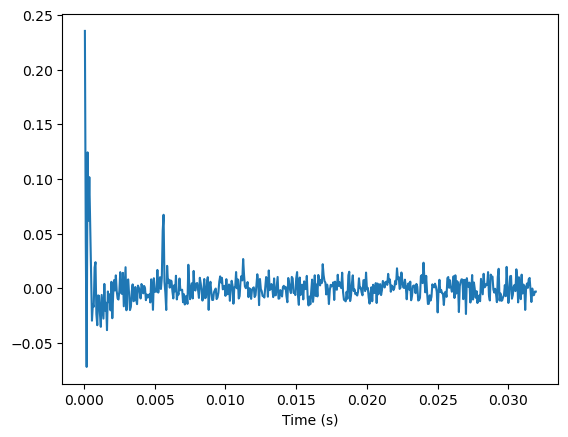

In [133]:
vowel = data[-640:]

realCepstrum = np.fft.ifft(np.log10(np.abs(np.fft.fft(vowel, 1024))), 1024)
N_cepstrum   = len(realCepstrum)
t            = np.arange(0, len(realCepstrum)/Fs, 1/Fs)

# Only plotting half because of symmetry
# Plotting from index 1 and onwards because of a large 'DC'-component at index 0 (infinite frequency)
plt.plot(t[1:N_cepstrum//2], realCepstrum[1:N_cepstrum//2])
plt.xlabel("Time (s)")
plt.show()

(b) Use the cepstrum to compute the fundamental frequency $f_0$. Compare your results with those obtained in problem 1).

To find the fundamental frequency $f_0$, we need to analyze the cepstrum to find the slowest varying component of the spectrum (excluding harmonics).

There is a peak in between 5ms and 7.5ms most likely indicating the fundamental frequency.

We can therefore search in the interval [5ms, 7.5ms] for the time where this peak lies.

In [135]:
# Finding the indices for 5ms and 7.5ms respectively
firstIndex  = np.where(t == 0.005)[0][0]
secondIndex = np.where(t == 0.0075)[0][0]

t_max_from_5ms = np.argmax(np.abs(realCepstrum[firstIndex:secondIndex]))
T_fundamental = t[firstIndex] + t[t_max_from_5ms] # Applying the offset of 5ms (first index)
f_fundamental = 1/T_fundamental

print("The fundamental frequency is approximately", np.round(f_fundamental, 2), "Hz")

The fundamental frequency is approximately 177.78 Hz


This fundamental frequency is a bit lower than the ones calculated in problem 1. Again, this error might be due to misinterpretation / inaccuracy in interpreting the plots earlier. This last method is more reliable, but can still have an error given that the true fundamental frequency is not exactly at the peak, but instead varying around it.

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.

To get the part representing the spectral envelope from the cepstrum, the lifter should be a 'low-pass' with a bandpass from 0ms to approximately 4.5ms.

4.5ms is selected to have some margin to the area where the fundamental frequency is (a little over 5ms).

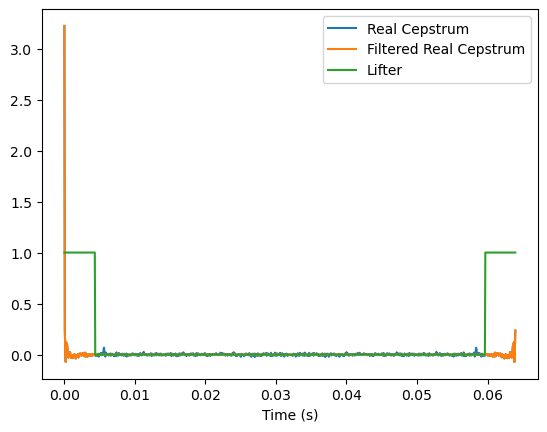

In [136]:
# Creating an ideal (and symmetric) low-pass filter from 0ms to 4.5ms
index = np.where(t == 0.004375)[0][0] # Closest value to 4.5ms
lifter = np.zeros(len(realCepstrum))
for i in range(len(lifter[:index])):
    lifter[i]  = 1
    lifter[-i] = 1

lifteredCepstrum = realCepstrum*lifter

plt.plot(t, realCepstrum)
plt.plot(t, lifteredCepstrum)
plt.plot(t, lifter)
plt.legend(["Real Cepstrum", "Filtered Real Cepstrum", "Lifter"])
plt.xlabel("Time (s)")
plt.show()

To get the spectrum again from the cepstrum:
First take the FFT of the cepstrum, then take the exponential of this to remove the logarithm.

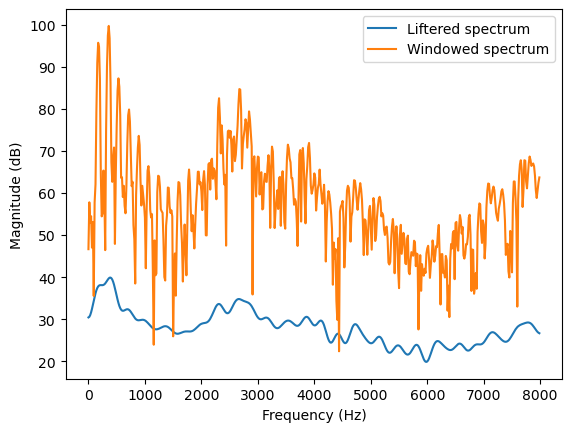

In [143]:
spectrumLiftered   = np.exp(np.fft.fft(lifteredCepstrum, 1024))
freqLiftered       = np.fft.fftfreq(len(spectrumLiftered), 1/Fs)
N_spectrumLiftered = len(spectrumLiftered)

plt.plot(freqLiftered[:N_spectrumLiftered//2], 20*np.log10(np.abs(spectrumLiftered[:N_spectrumLiftered//2])))
plt.plot(freqLiftered[:N_spectrumLiftered//2], 20*np.log10(np.abs(spectrumWindowed))[:N_spectrumLiftered//2])
plt.legend(["Liftered spectrum", "Windowed spectrum"])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

As one can see from the plot, the liftered spectrum follows the form of the formants in the original windowed spectrum without the harmonics. It is not a perfect representation, which might be because of multiple reasons. For example the spectrum still including noise and the fact that and ideal lifter was used (almost as windowing in cepstral domain) are reasons for the non-perfect representation. Still, it is good enough to see the spectral envelope.